# Predizione tutte le waves

In [1]:
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from aidam.math_utils import moving_function_rev1
#from aidam.aicharts import get_subplot_cells_sequence, confplot_ax,auto_grid_shape
#from aidam.faga.curve_fit import FagaCurveFit
from scipy.optimize import curve_fit
from datetime import datetime, timedelta
from aidam.miscellanea_utils import find_matlabstyle

from covid_lib import read_covid_data, find_day_index

## Lettura dati

In [2]:
trend,regioni,giorni,giorno_settimana,popolazione,day_counter=read_covid_data('stored_data.pkl')

Giorni osservati: 816
Primo giorno: 2020-02-24T18:00:00
Ultimo giorno: 2022-05-19T17:00:00


## Estrapolazione second wave

Inizio nominale second wave: 2021-10-16T17:00:00


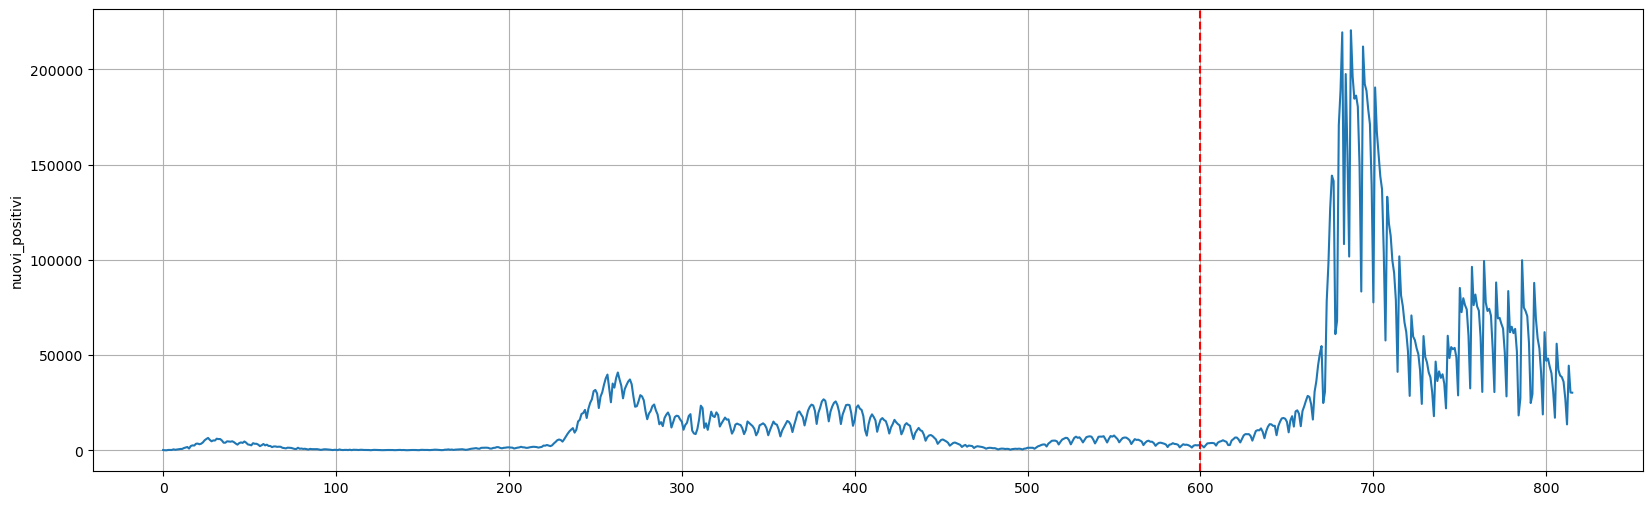

Valore nuovi_positivi a inizio second wave: 2983.000000


In [3]:
indicatore='nuovi_positivi'
regione='Italia'

# giorno di inizio second wave
if indicatore=='terapia_intensiva':
    sw_start=150
if indicatore=='deceduti_giornalieri':
    sw_start=600
if indicatore=='nuovi_positivi':
    sw_start=600

    
print('Inizio nominale second wave: %s'%giorni[sw_start])



fig,ax=plt.subplots(1,figsize=(20,6))
ax.plot(day_counter,trend[indicatore][regione])
ax.grid()
ax.set_ylabel(indicatore)
ax.axvline(sw_start,c='r',ls='--')
plt.show()

Y=trend[indicatore][regione][sw_start:]


print('Valore %s a inizio second wave: %f'%(indicatore,trend[indicatore][regione][sw_start]))

## Multi-gaussiane

In [4]:
def generic_gaussian(t,a,b,c):
    # a: altezza picco
    # b: giorno centrale
    # c: deviazione standard
    return a*np.exp(-((t-b)**2)/(2*c**2))

def multi_gaussian_creator(t,num_gaussiane,pars):
    temp=0
    for i in range(num_gaussiane):
        temp+=generic_gaussian(t,*pars[i*3:i*3+3])
    return temp

In [21]:
num_gaussians=2

my_multi_gaussian=lambda t,*pars: multi_gaussian_creator(t,num_gaussians,pars)
#start_point=[1,1,1,1,1,1]

# versione automatica
minimi=num_gaussians*[0,0,0]
massimi=num_gaussians*[1.2*np.max(Y),np.round(len(Y)*1),np.round(0.25*len(Y))]

'''
# versione manuale
# data picco
minimi[7]=len(Y)-10
massimi[7]=len(Y)+20
# altezza picco
minimi[6]=0.8*np.max(Y)
massimi[6]=1.1*np.max(Y)
'''

bounds=(minimi,massimi)
start_point=(np.array(bounds[0])+np.array(bounds[1]))/2

#three_gaussians=lambda t,*pars: multi_gaussian(t,3,pars)
#start_point=[1,1,1,1,1,1,1,1,1]

'''
three_gaussians=lambda t,*pars: multi_gaussian(t,3,pars)
# bounds per 3 gaussiane su nuovi positivi
bounds=([1000,10,0,20000,220,0,10000,300,0],[10000,100,100,50000,300,100,50000,500,100])
start_point=(np.array(bounds[0])+np.array(bounds[1]))/2
'''

'\nthree_gaussians=lambda t,*pars: multi_gaussian(t,3,pars)\n# bounds per 3 gaussiane su nuovi positivi\nbounds=([1000,10,0,20000,220,0,10000,300,0],[10000,100,100,50000,300,100,50000,500,100])\nstart_point=(np.array(bounds[0])+np.array(bounds[1]))/2\n'

In [22]:
print(bounds)
print(start_point)

([0, 0, 0, 0, 0, 0], [264638.39999999997, 216, 54.0, 264638.39999999997, 216, 54.0])
[1.323192e+05 1.080000e+02 2.700000e+01 1.323192e+05 1.080000e+02
 2.700000e+01]


In [23]:
modello_usato=my_multi_gaussian
#solution,pcov=curve_fit(modello_usato,np.arange(len(Y)),Y,p0=start_point)

# questo per limitare i giorni per il tuning
no_last_days=7

#solution,pcov=curve_fit(modello_usato,np.arange(len(Y)),Y,bounds=bounds,p0=start_point)
if no_last_days>0:
    solution,pcov=curve_fit(modello_usato,np.arange(len(Y)-no_last_days),Y[:-no_last_days],bounds=bounds,p0=start_point)
else:
    solution,pcov=curve_fit(modello_usato,np.arange(len(Y)),Y,bounds=bounds,p0=start_point)

solution

array([6.70617069e+04, 1.68748323e+02, 3.48120483e+01, 1.73552148e+05,
       9.15549095e+01, 1.51140450e+01])

## Simulazione

In [24]:
simulation_days=np.arange(len(Y)+90)
y_pred=np.array(list(map(lambda x:modello_usato(x,*solution),simulation_days)))

Preparazione date

- creo il giorno 0 nel formato *datetime* per poi creare i nuovi plot su questa base
- creo una lista di giorni (in formato di stringhe) partendo dal giorno0

In [25]:
giorno0=datetime.strptime(giorni[sw_start][0:10], "%Y-%m-%d")
str_giorni=[]
for d in range(500):
    str_giorni.append((giorno0+timedelta(d)).strftime("%Y-%m-%d"))
str_giorni=np.array(str_giorni)

oggi=datetime.strftime(datetime.now(), "%Y-%m-%d")
indice_oggi=find_matlabstyle(str_giorni,lambda x:x==oggi)[0]

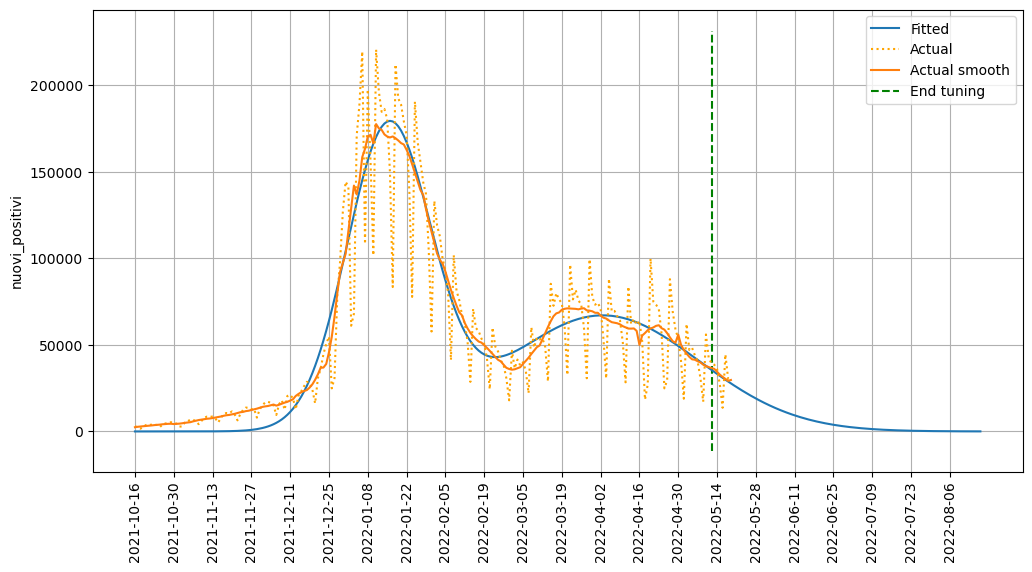

In [26]:
fig,ax=plt.subplots(1,figsize=(12,6))
ax.plot(simulation_days,y_pred,label='Fitted',linestyle='-')
ax.plot(range(len(Y)),Y,label='Actual',linestyle=':',color='orange')
ax.plot(range(len(Y)),moving_function_rev1(Y,np.mean,3,3),label='Actual smooth')
ax.vlines(len(Y)-no_last_days-1,ax.get_ylim()[0],ax.get_ylim()[1],linestyles='--',color='g',label='End tuning')
ax.grid()
ax.set_xticks(list(range(0,len(simulation_days),14)))
ax.set_xticklabels(str_giorni[list(range(0,len(simulation_days),14))],rotation=90)

ax.set_ylabel(indicatore)
ax.legend()
plt.show()

In [27]:
ax.get_ylim()

(-23155.272551006055, 243687.8041790549)

In [28]:
for d in simulation_days:
    if d<len(Y):
        print('[%3d]  %s  Act: %6d Pred: %.1f [Diff: %.1f]'%(d,str_giorni[d],Y[d],y_pred[d],y_pred[d]-Y[d]))
    else:
        print('[%3d]  %s  Act: %6d Pred: %.1f'%(d,str_giorni[d],0,y_pred[d]))   

[  0]  2021-10-16  Act:   2983 Pred: 0.5 [Diff: -2982.5]
[  1]  2021-10-17  Act:   2437 Pred: 0.6 [Diff: -2436.4]
[  2]  2021-10-18  Act:   1597 Pred: 0.7 [Diff: -1596.3]
[  3]  2021-10-19  Act:   2697 Pred: 0.8 [Diff: -2696.2]
[  4]  2021-10-20  Act:   3702 Pred: 0.9 [Diff: -3701.1]
[  5]  2021-10-21  Act:   3794 Pred: 1.1 [Diff: -3792.9]
[  6]  2021-10-22  Act:   3882 Pred: 1.2 [Diff: -3880.8]
[  7]  2021-10-23  Act:   3908 Pred: 1.4 [Diff: -3906.6]
[  8]  2021-10-24  Act:   3725 Pred: 1.6 [Diff: -3723.4]
[  9]  2021-10-25  Act:   2535 Pred: 1.9 [Diff: -2533.1]
[ 10]  2021-10-26  Act:   4054 Pred: 2.1 [Diff: -4051.9]
[ 11]  2021-10-27  Act:   4598 Pred: 2.4 [Diff: -4595.6]
[ 12]  2021-10-28  Act:   4866 Pred: 2.8 [Diff: -4863.2]
[ 13]  2021-10-29  Act:   5335 Pred: 3.3 [Diff: -5331.7]
[ 14]  2021-10-30  Act:   4878 Pred: 3.8 [Diff: -4874.2]
[ 15]  2021-10-31  Act:   4526 Pred: 4.4 [Diff: -4521.6]
[ 16]  2021-11-01  Act:   2818 Pred: 5.1 [Diff: -2812.9]
[ 17]  2021-11-02  Act:   2834 